In [47]:
# Consolidated imports and basic paths — put this code in the first notebook cell.

import os
import json
import math
import warnings
import time
import hashlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    RobustScaler,
    FunctionTransformer,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

import joblib

# prevent noisy warnings during training
warnings.filterwarnings("ignore")

# --- Paths (keep original behavior)
ROOT = Path.cwd()
DATA_DIR = ROOT / "data_audit"
OUT_DIR = ROOT / "outputs"
MODEL_DIR = OUT_DIR / "models"
REPORT_DIR = OUT_DIR / "reports"
PLOTS_DIR = OUT_DIR / "plots"

for d in [DATA_DIR, MODEL_DIR, REPORT_DIR, PLOTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

CSV_PATH = DATA_DIR / "train_LOGR1.csv"

FEATURE_ORDER = [
    "beneficio_ativo", "tempo_beneficio_meses",
    "emprego_ativo", "tempo_emprego_meses",
    "renda_media_6m", "coef_var_renda", "pct_meses_saldo_neg_6m",
    "utilizacao_cartao", "pct_minimo_pago_3m", "num_faturas_vencidas_3m",
    "endividamento_total", "parcelas_renda", "DPD_max_12m",
    "idade", "tempo_rel_banco_meses",
]

TARGET_COL = "default90"

In [48]:
# === Carregamento dos dados
if CSV_PATH.exists():
    df = pd.read_csv(CSV_PATH)
    print(f'Carregado: {CSV_PATH} -> {df.shape}')

# Garante presença das colunas esperadas
for c in FEATURE_ORDER:
    if c not in df.columns:
        df[c] = 0.0

# Salva a versão consolidada (útil para auditoria)
df.to_csv(CSV_PATH, index=False)
df.head(3)

Carregado: /Users/guilhermepifferchristo/Desktop/ConsignP2P-QITech/mlops/training/risk__LOGR1/data_audit/train_LOGR1.csv -> (12000, 16)


,beneficio_ativo,tempo_beneficio_meses,emprego_ativo,tempo_emprego_meses,renda_media_6m,coef_var_renda,pct_meses_saldo_neg_6m,utilizacao_cartao,pct_minimo_pago_3m,num_faturas_vencidas_3m,endividamento_total,parcelas_renda,DPD_max_12m,idade,tempo_rel_banco_meses,default90
0,0,0,1,20,1655.15,0.611,0.592,0.783,0.589,1,15154.07,0.470,0,24,7,1
1,1,24,0,0,4231.61,0.136,0.135,0.703,0.262,0,48973.87,0.424,0,70,36,0
2,0,0,0,0,1205.30,0.521,0.595,0.497,0.291,1,5292.87,0.435,0,62,19,0


In [49]:
# === Carregamento dos dados
if CSV_PATH.exists():
    df = pd.read_csv(CSV_PATH)
    print(f'Carregado: {CSV_PATH} -> {df.shape}')
else:
    # Fallback: gera dataset sintético para rodar o notebook.
    rng = np.random.default_rng(42)
    n = 3000
    df = pd.DataFrame({
        'beneficio_ativo': rng.integers(0,2,size=n),
        'tempo_beneficio_meses': rng.normal(120, 60, n).clip(0, 480),
        'emprego_ativo': rng.integers(0,2,size=n),
        'tempo_emprego_meses': rng.normal(48, 30, n).clip(0, 360),
        'renda_media_6m': rng.normal(4000, 1500, n).clip(800, 20000),
        'coef_var_renda': rng.normal(0.2, 0.1, n).clip(0, 1.0),
        'pct_meses_saldo_neg_6m': rng.normal(0.15, 0.2, n).clip(0, 1.0),
        'utilizacao_cartao': rng.normal(0.45, 0.25, n).clip(0, 2.0),
        'pct_minimo_pago_3m': rng.normal(0.12, 0.15, n).clip(0, 1.0),
        'num_faturas_vencidas_3m': rng.poisson(0.3, n),
        'endividamento_total': rng.normal(7000, 6000, n).clip(0, 100000),
        'parcelas_renda': rng.normal(0.25, 0.15, n).clip(0, 1.5),
        'DPD_max_12m': rng.integers(0, 120, size=n),
        'idade': rng.integers(18, 85, size=n),
        'tempo_rel_banco_meses': rng.integers(1, 360, size=n)
    })
    print('**Dataset sintético gerado (fallback)**:', df.shape)
    
# Garante presença das colunas esperadas
for c in FEATURE_ORDER:
    if c not in df.columns:
        df[c] = 0.0

# Se não houver target real, gera um label proxy simples
if TARGET_COL not in df.columns:
    # Regras proxy (exemplo simples para demo):
    cond = (
        (df['DPD_max_12m'] >= 60) |
        (df['num_faturas_vencidas_3m'] >= 1) |
        ((df['utilizacao_cartao'] >= 0.9) & (df['coef_var_renda'] >= 0.3))
    )
    df[TARGET_COL] = np.where(cond, 1, 0).astype(int)
    print('**Label proxy criado (default90)** — substitua por rótulo real quando disponível.')

# Salva a versão consolidada (útil para auditoria)
df.to_csv(CSV_PATH, index=False)
df.head(3)


Carregado: /Users/guilhermepifferchristo/Desktop/ConsignP2P-QITech/mlops/training/risk__LOGR1/data_audit/train_LOGR1.csv -> (12000, 16)


,beneficio_ativo,tempo_beneficio_meses,emprego_ativo,tempo_emprego_meses,renda_media_6m,coef_var_renda,pct_meses_saldo_neg_6m,utilizacao_cartao,pct_minimo_pago_3m,num_faturas_vencidas_3m,endividamento_total,parcelas_renda,DPD_max_12m,idade,tempo_rel_banco_meses,default90
0,0,0,1,20,1655.15,0.611,0.592,0.783,0.589,1,15154.07,0.470,0,24,7,1
1,1,24,0,0,4231.61,0.136,0.135,0.703,0.262,0,48973.87,0.424,0,70,36,0
2,0,0,0,0,1205.30,0.521,0.595,0.497,0.291,1,5292.87,0.435,0,62,19,0


In [50]:
# === Split e pipeline LOGR1 (com interação CLT×INSS) - use DataFrame inputs

# ensure feature columns present and numeric (keep as DataFrame)
Xdf = df[FEATURE_ORDER].astype(float).copy()

# create explicit interaction column (INSS beneficiary AND CLT employed)
Xdf['ambos'] = (Xdf['beneficio_ativo'] * Xdf['emprego_ativo']).astype(float)

# define feature blocks by name (avoid duplications)
poly_features = ['utilizacao_cartao','pct_minimo_pago_3m','parcelas_renda','coef_var_renda']
interaction_feature = 'ambos'
exclude = set(poly_features) | {'beneficio_ativo','emprego_ativo'}
others = [c for c in Xdf.columns if c not in exclude and c != interaction_feature]

# target as Series
y = df[TARGET_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    Xdf, y, test_size=0.3, random_state=42, stratify=y
)

# ColumnTransformer using column names (works because X_train is a DataFrame)
col_transformer = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False), poly_features),
        ('others', 'passthrough', others),
        ('ambos', 'passthrough', [interaction_feature]),
    ],
    remainder='drop',
    verbose_feature_names_out=False,
)

# Pipeline: column transform -> impute -> scale -> classifier
# IMPORTANT: ColumnTransformer must receive a DataFrame when using column names.
pipe = Pipeline(steps=[
    ('cols', col_transformer),                          # keep as first step
    ('imputer', SimpleImputer(strategy='median')),     # now works on array produced by ColumnTransformer
    ('scaler', RobustScaler()),
    ('clf', LogisticRegression(
        solver='saga',
        penalty='elasticnet',
        l1_ratio=0.8,
        C=0.4,
        class_weight='balanced',
        max_iter=3000,
        tol=1e-6,
        random_state=42
    ))
])

# Ensure X_train / X_test are DataFrame (ColumnTransformer expects DataFrame when configured with names)
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=Xdf.columns)
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=Xdf.columns)

# Train and evaluate
pipe.fit(X_train, y_train)
pd_test = pipe.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, pd_test)
brier = brier_score_loss(y_test, pd_test)
fpr, tpr, thr = roc_curve(y_test, pd_test)
ks = float((tpr - fpr).max())

print({'AUC': round(auc, 4), 'KS': round(ks, 4), 'Brier': round(brier, 6)})


{'AUC': 0.6956, 'KS': 0.2855, 'Brier': 0.216467}


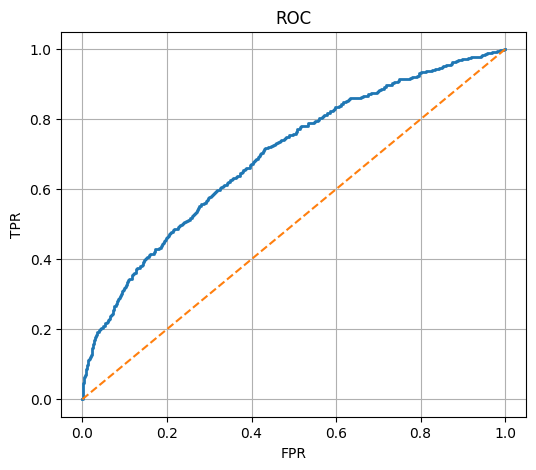

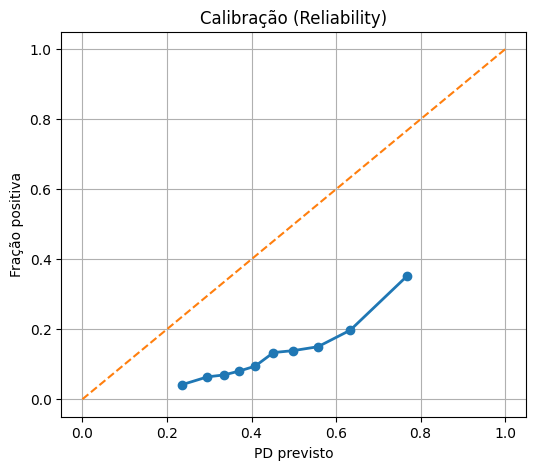

In [51]:
# === Plots: ROC e Curva de Calibração
# ROC
fpr, tpr, thr = roc_curve(y_test, pd_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1], linestyle='--')
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid(True)
plt.show()

# Calibração (reliability curve)
prob_true, prob_pred = calibration_curve(y_test, pd_test, n_bins=10, strategy='quantile')
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2)
plt.plot([0,1],[0,1], linestyle='--')
plt.title('Calibração (Reliability)')
plt.xlabel('PD previsto')
plt.ylabel('Fração positiva')
plt.grid(True)
plt.show()


{'AUC_cal': 0.6961, 'KS_cal': 0.2839, 'Brier_cal': 0.105471}


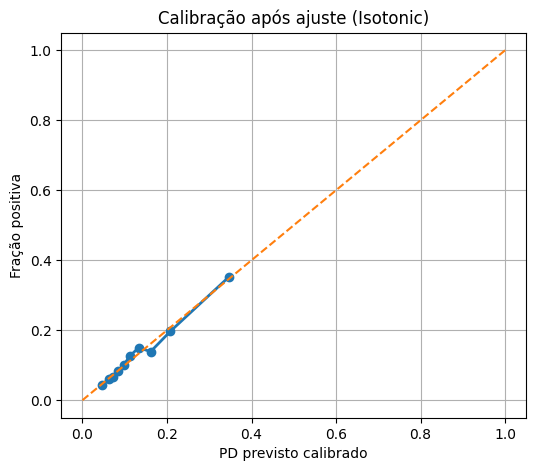

In [58]:
# === (Opcional) Calibração via Isotonic ou Sigmoid
do_calibrate = True

if do_calibrate:
    calibrator = CalibratedClassifierCV(pipe, method='sigmoid', cv=3)
    calibrator.fit(X_train, y_train)
    pd_test_cal = calibrator.predict_proba(X_test)[:,1]
    auc_cal = roc_auc_score(y_test, pd_test_cal)
    brier_cal = brier_score_loss(y_test, pd_test_cal)
    fpr_c, tpr_c, _ = roc_curve(y_test, pd_test_cal)
    ks_cal = np.max(tpr_c - fpr_c)
    print({'AUC_cal': round(auc_cal,4), 'KS_cal': round(float(ks_cal),4), 'Brier_cal': round(brier_cal,6)})
    
    # Plot calibração pós-ajuste
    prob_true_c, prob_pred_c = calibration_curve(y_test, pd_test_cal, n_bins=10, strategy='quantile')
    plt.figure(figsize=(6,5))
    plt.plot(prob_pred_c, prob_true_c, marker='o', linewidth=2)
    plt.plot([0,1],[0,1], linestyle='--')
    plt.title('Calibração após ajuste (Isotonic)')
    plt.xlabel('PD previsto calibrado')
    plt.ylabel('Fração positiva')
    plt.grid(True)
    plt.show()
else:
    calibrator = None


In [59]:
# === Salvar artefatos
import joblib, hashlib, time

model_to_save = calibrator if calibrator is not None else pipe
model_path = MODEL_DIR / 'pd_logr1.joblib'
joblib.dump(model_to_save, model_path)

meta = {
    'model_file': str(model_path),
    'features': FEATURE_ORDER,
    'target': TARGET_COL,
    'n_train': int(len(y_train)),
    'n_test': int(len(y_test)),
    'metrics': {
        'auc': float(roc_auc_score(y_test, model_to_save.predict_proba(X_test)[:,1])),
        'ks':  float(np.max(roc_curve(y_test, model_to_save.predict_proba(X_test)[:,1])[1] - 
                            roc_curve(y_test, model_to_save.predict_proba(X_test)[:,1])[0])),
        'brier': float(brier_score_loss(y_test, model_to_save.predict_proba(X_test)[:,1]))
    },
    'calibrated': calibrator is not None,
    'created_at': int(time.time())
}

report_path = REPORT_DIR / 'risco_baseline.json'
with open(report_path, 'w') as f:
    json.dump(meta, f, indent=2)

print('Modelo salvo em:', model_path)
print('Relatório salvo em:', report_path)


Modelo salvo em: /Users/guilhermepifferchristo/Desktop/ConsignP2P-QITech/mlops/training/risk__LOGR1/outputs/models/pd_logr1.joblib
Relatório salvo em: /Users/guilhermepifferchristo/Desktop/ConsignP2P-QITech/mlops/training/risk__LOGR1/outputs/reports/risco_baseline.json


In [60]:
# Prévia: tabela com 5 exemplos do conjunto de teste (PD previsto)
preview = pd.DataFrame(X_test[:5], columns=X_test.columns).copy()
preview['pd_pred'] = model_to_save.predict_proba(X_test[:5])[:,1]
preview.reset_index(drop=True, inplace=True)
preview

,beneficio_ativo,tempo_beneficio_meses,emprego_ativo,tempo_emprego_meses,renda_media_6m,coef_var_renda,pct_meses_saldo_neg_6m,utilizacao_cartao,pct_minimo_pago_3m,num_faturas_vencidas_3m,endividamento_total,parcelas_renda,DPD_max_12m,idade,tempo_rel_banco_meses,ambos,pd_pred
0,0.0,0.0,0.0,0.0,1784.12,0.823,0.813,0.530,0.579,0.0,23397.11,0.588,6.0,48.0,5.0,0.0,0.183923
1,0.0,0.0,1.0,12.0,3064.39,0.507,0.493,0.268,0.305,2.0,16023.72,0.564,41.0,48.0,33.0,0.0,0.131462
2,0.0,0.0,1.0,27.0,5749.13,0.103,0.229,0.266,0.098,1.0,46670.09,0.453,40.0,76.0,29.0,0.0,0.077785
3,0.0,0.0,0.0,0.0,1066.66,0.708,0.825,0.670,0.331,1.0,5162.95,0.390,0.0,37.0,10.0,0.0,0.166912
4,0.0,0.0,0.0,0.0,1580.92,0.656,0.693,0.250,0.131,0.0,3020.57,0.305,0.0,55.0,22.0,0.0,0.059739
